# Deep Learning Graduate Course Competition

*By: Omar Rayyan (olr7742), Mahmoud Hafez (Mah9935), Rameen Mahmoud*

**Importing Required Libraries and Functions**

In [2]:
import torch
import torch.optim as optim
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from resnet import ResNet
from utils import get_data_loaders, save_checkpoint, load_checkpoint
from trainer import mixup_train, train, test

**Global Parameters**

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_PATH = "data"

In [6]:
DEVICE

device(type='cuda')

**Initializing Our Model (implementation [here](resnet.py))**

In [4]:
model = ResNet(num_blocks=[4,3,2,3]).to(DEVICE)

**Parameters in our Model**

In [5]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 4993166


**Transforms**

In [8]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(0.2),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomAutocontrast(0.2),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

**Setting Up Data Loaders**

In [9]:
train_loader, test_loader = get_data_loaders(dataset_path=DATA_PATH,batch_size=128,test_transform=test_transform, train_transform=train_transform)

**Model Hyperparameters**

In [10]:
start_epoch = 0
end_epoch = 400
weight_decay = 0.0005
learning_rate = 0.1
momentum = 0.9

loss_function = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=end_epoch-start_epoch)

**Loading Model Checkpoint**

In [11]:
# load_checkpoint(model, optimizer, "checkpoints/9663.tar")

**Training Model**

In [12]:
train_loss_history = []
train_accuracy_history = []
test_loss_history = []
test_accuracy_history = []

In [16]:
for epoch in range(400, 450):
    
    # if np.random.rand()<0.9:
    #     train_loss, train_accuracy = mixup_train(model, optimizer, loss_function, train_loader, DEVICE)
    # else:
    train_loss, train_accuracy = train(model, optimizer, loss_function, train_loader, DEVICE)
    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)
    
    test_loss, test_accuracy = test(model, loss_function, test_loader, DEVICE)
    test_loss_history.append(test_loss)
    test_accuracy_history.append(test_accuracy)
    
    scheduler.step()
    
    save_checkpoint(model,optimizer,epoch,"my_checkpoint.tar")
    
    print(f'Epoch {epoch}, Train loss {train_loss}, Test loss {test_loss}, Train accuracy {train_accuracy}, Test accuracy {test_accuracy}')

Epoch 400, Train loss 0.014348382737649523, Test loss 0.12138111120726489, Train accuracy 0.99904, Test accuracy 0.9675
Epoch 401, Train loss 0.014729885351093834, Test loss 0.12170933234163478, Train accuracy 0.99908, Test accuracy 0.967
Epoch 402, Train loss 0.0145594567617835, Test loss 0.12039253000122836, Train accuracy 0.99894, Test accuracy 0.9676
Epoch 403, Train loss 0.013980177390720229, Test loss 0.11985368783809716, Train accuracy 0.99898, Test accuracy 0.9677
Epoch 404, Train loss 0.013346805401584682, Test loss 0.11892310506369494, Train accuracy 0.99906, Test accuracy 0.9686
Epoch 405, Train loss 0.012744046669081806, Test loss 0.1179618379454824, Train accuracy 0.99888, Test accuracy 0.9677
Epoch 406, Train loss 0.011665336079085651, Test loss 0.11714075194506705, Train accuracy 0.99918, Test accuracy 0.9678
Epoch 407, Train loss 0.011557998148786367, Test loss 0.11751291601435293, Train accuracy 0.9989, Test accuracy 0.9672
Epoch 408, Train loss 0.01065395205207836, Te

In [15]:
np.save("plots/train_loss_history.npy", train_loss_history)
np.save("plots/train_accuracy_history.npy", train_accuracy_history)
np.save("plots/test_loss_history.npy", test_loss_history)
np.save("plots/test_accuracy_history.npy", test_accuracy_history)

In [4]:
train_loss_history = np.load("plots/train_loss_history.npy")
train_accuracy_history = np.load("plots/train_accuracy_history.npy")
test_loss_history = np.load("plots/test_loss_history.npy")
test_accuracy_history = np.load("plots/test_accuracy_history.npy")

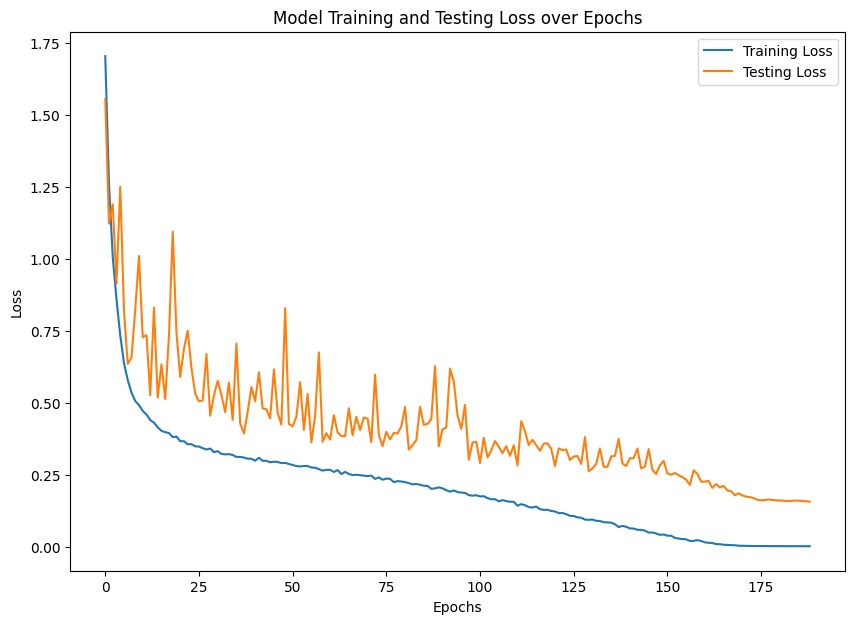

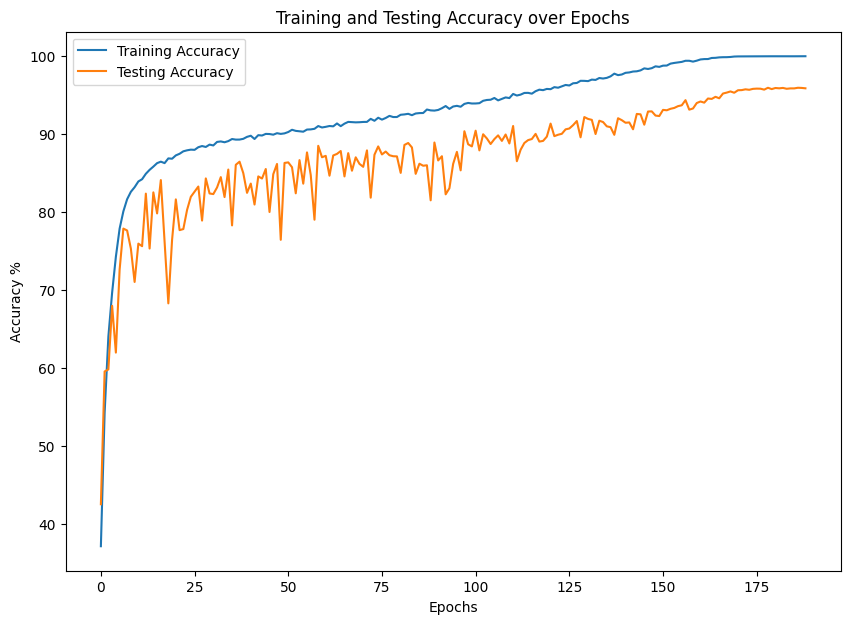

In [5]:
epochs = range(0, len(train_loss_history)) 

# Plotting training and testing losses
plt.figure(figsize=(10, 7))
plt.plot(epochs, train_loss_history, label='Training Loss')
plt.plot(epochs, test_loss_history, label='Testing Loss')
plt.title('Model Training and Testing Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and testing accuracies
plt.figure(figsize=(10, 7))
plt.plot(epochs, train_accuracy_history/0.01, label='Training Accuracy')
plt.plot(epochs, test_accuracy_history/0.01, label='Testing Accuracy')
plt.title('Training and Testing Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy %')
plt.legend()
plt.show()